# Summary

本報告旨在實作一個雙層神經網路，並應用於 MNIST 手寫數字資料集的分類任務 。為符合要求，整個神經網路模型，包括其訓練過程，均使用 Python 和 NumPy 函式庫從零開始搭建，不依賴任何現有的機器學習框架。

實作流程始於資料的獲取與前處理。首先，由於原始 MNIST 資料集網站的下載問題，我改由穩定的 GitHub mirror 來源獲取資料 。接著，對資料進行標準化前處理，包含將 28×28 的二維圖片資料拉平為 784 維的特徵向量 ，將像素值 normalize 至 0 到 1 的區間 ，並對分類標籤進行 One-Hot Encode，以便於後續損失函數的計算。

神經網路的核心架構包含一個使用 ReLU 作為激活函數的隱藏層，以及一個使用 Softmax 函數進行多類別機率輸出的輸出層。這份 ipynb 完整地實作了模型訓練的關鍵演算法，包括：

- 前向傳播 (Forward Propagation)：根據輸入資料與當前參數計算預測輸出 。
- 損失函數 (Loss Function)：採用 Cross-Entropy Loss 來衡量預測與正解間的差異。
- 反向傳播 (Backward Propagation)：計算損失函數對各層參數的梯度。
- 參數更新 (Update Parameters)：根據計算出的梯度，透過梯度下降法來迭代優化模型權重。

整個訓練過程採用小批次梯度下降 (Mini-batch Gradient Descent) 的方式，並在每個訓練世代 (epoch) 開始前對資料進行隨機洗牌，以提升模型的泛化能力。

# Step 0: 下載資料集

In [23]:
# 從 Github mirror 下載資料集（原作者 http://yann.lecun.com/exdb/mnist/ 似乎資料已刪除）


def get_mnist():
    """
    The code to download the mnist data original came from
    https://cntk.ai/pythondocs/CNTK_103A_MNIST_DataLoader.html
    """

    import gzip
    import numpy as np
    import os
    import struct

    from urllib.request import urlretrieve

    def load_data(src, num_samples):
        print("Downloading " + src)
        gzfname, h = urlretrieve(src, "./delete.me")
        print("Done.")
        try:
            with gzip.open(gzfname) as gz:
                n = struct.unpack("I", gz.read(4))
                # Read magic number.
                if n[0] != 0x3080000:
                    raise Exception("Invalid file: unexpected magic number.")
                # Read number of entries.
                n = struct.unpack(">I", gz.read(4))[0]
                if n != num_samples:
                    raise Exception(f"Invalid file: expected {num_samples} entries.")
                crow = struct.unpack(">I", gz.read(4))[0]
                ccol = struct.unpack(">I", gz.read(4))[0]
                if crow != 28 or ccol != 28:
                    raise Exception("Invalid file: expected 28 rows/cols per image.")
                # Read data.
                res = np.frombuffer(gz.read(num_samples * crow * ccol), dtype=np.uint8)
        finally:
            os.remove(gzfname)
        return res.reshape((num_samples, crow, ccol)) / 256 # 順便做了 normalize

    def load_labels(src, num_samples):
        print("Downloading " + src)
        gzfname, h = urlretrieve(src, "./delete.me")
        print("Done.")
        try:
            with gzip.open(gzfname) as gz:
                n = struct.unpack("I", gz.read(4))
                # Read magic number.
                if n[0] != 0x1080000:
                    raise Exception("Invalid file: unexpected magic number.")
                # Read number of entries.
                n = struct.unpack(">I", gz.read(4))
                if n[0] != num_samples:
                    raise Exception(f"Invalid file: expected {num_samples} rows.")
                # Read labels.
                res = np.frombuffer(gz.read(num_samples), dtype=np.uint8)
        finally:
            os.remove(gzfname)
        return res.reshape(num_samples)

    def try_download(data_source, label_source, num_samples):
        data = load_data(data_source, num_samples)
        labels = load_labels(label_source, num_samples)
        return data, labels

    # Not sure why, but yann lecun's website does no longer support
    # simple downloader. (e.g. urlretrieve and wget fail, while curl work)
    # Since not everyone has linux, use a mirror from uni server.
    #     server = 'http://yann.lecun.com/exdb/mnist'
    server = "https://raw.githubusercontent.com/fgnt/mnist/master"

    # URLs for the train image and label data
    url_train_image = f"{server}/train-images-idx3-ubyte.gz"
    url_train_labels = f"{server}/train-labels-idx1-ubyte.gz"
    num_train_samples = 60000

    print("Downloading train data")
    train_features, train_labels = try_download(url_train_image, url_train_labels, num_train_samples)

    # URLs for the test image and label data
    url_test_image = f"{server}/t10k-images-idx3-ubyte.gz"
    url_test_labels = f"{server}/t10k-labels-idx1-ubyte.gz"
    num_test_samples = 10000

    print("Downloading test data")
    test_features, test_labels = try_download(url_test_image, url_test_labels, num_test_samples)

    return train_features, train_labels, test_features, test_labels


In [24]:
train_features, train_labels, test_features, test_labels = get_mnist()

Done.
Done.
Done.
Done.


In [25]:
import os

os.makedirs("data", exist_ok=True)  # 確保 data 資料夾存在

In [26]:
import numpy as np

np.savez_compressed(
    "data/mnist_dataset.npz", train_x=train_features, train_y=train_labels, test_x=test_features, test_y=test_labels
)


# Step 1: Data Processing

## Step 1-1: Read data and reshape

In [27]:
# 讀取已儲存的 .npz 檔案
mnist_data = np.load("data/mnist_dataset.npz")

# 透過儲存時設定的關鍵字名稱，來取出各個 NDArray
train_x_orig = mnist_data["train_x"]
train_y_orig = mnist_data["train_y"]
test_x_orig = mnist_data["test_x"]
test_y_orig = mnist_data["test_y"]

# 驗證一下 shape
print("train_x_orig.shape:", train_x_orig.shape)
print("train_y_orig.shape:", train_y_orig.shape)
print("test_x_orig.shape:", test_x_orig.shape)
print("test_y_orig.shape:", test_y_orig.shape)

train_x_orig.shape: (60000, 28, 28)
train_y_orig.shape: (60000,)
test_x_orig.shape: (10000, 28, 28)
test_y_orig.shape: (10000,)


In [28]:
# 將 28x28 的圖片拉平成 784 的向量
# -1 會讓 numpy 自動計算該維度的數量
train_x = train_x_orig.reshape(train_x_orig.shape[0], -1)
test_x = test_x_orig.reshape(test_x_orig.shape[0], -1)

print("tran_x.shape:", train_x.shape)  # (60000, 784)
print("test_x.shape:", test_x.shape)  # (10000, 784)


tran_x.shape: (60000, 784)
test_x.shape: (10000, 784)


> 在下載的函數中已經將圖片的每個像素值除以 256，已經做完 Normalization

## Step 1-2: 對 Label 進行 One-Hot Encode

In [29]:
def one_hot_encode(labels, num_classes):
    # 創建一個全為 0 的矩陣，shape 為 (樣本數, 類別數)
    one_hot = np.zeros((labels.size, num_classes))
    # 在對應的類別位置上填上 1
    # np.arange(labels.size) 會產生 [0, 1, 2, ...] 用於定位行
    # labels 本身 ([5, 0, 4, ...]) 用於定位列
    one_hot[np.arange(labels.size), labels] = 1
    return one_hot


# 我們的類別是數字 0-9，所以有 10 個類別
num_classes = 10
train_y = one_hot_encode(train_y_orig, num_classes)
test_y = one_hot_encode(test_y_orig, num_classes)

print("One-Hot encode 前的 train_y.shape:", train_y_orig.shape)  # (60000,)
print("One-Hot 後的 train_y.shape:", train_y.shape)  # (60000, 10)
print(f"一個 One-Hot 編碼範例 (原始 label 是 {train_y_orig[0]}): {train_y[0]}")


One-Hot encode 前的 train_y.shape: (60000,)
One-Hot 後的 train_y.shape: (60000, 10)
一個 One-Hot 編碼範例 (原始 label 是 5): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


# Step 2: 實作神經網路

## Step 2-1: 初始化權重

初始化兩層神經網路的參數

參數:

- n_x -- 輸入層的神經元數量（784）
- n_h -- 隱藏層的神經元數量（例如 128）
- n_y -- 輸出層的神經元數量（10）

Return:

- parameters -- 一個包含 W1, b1, W2, b2 的 Python dict

In [30]:
def initialize_parameters(n_x, n_h, n_y):
    # 為了讓每次的隨機結果都一樣，設定一個隨機種子
    np.random.seed(42)

    # 初始化權重 W1 和 W2，使用常態分佈的隨機數並乘上一個小數 (如 0.01)
    # 這樣可以避免起始權重過大
    W1 = np.random.randn(n_x, n_h) * 0.01
    W2 = np.random.randn(n_h, n_y) * 0.01

    # 將 b1 初始化為一個微小的正數，例如 0.01，避免 dying ReLU
    b1 = np.ones((1, n_h)) * 0.01

    # b2 初始化為 0（它影響的是 softmax）
    b2 = np.zeros((1, n_y))

    # 將所有參數打包到一個字典中
    parameters = {"W1": W1, "b1": b1, "W2": W2, "b2": b2}

    return parameters

In [31]:
# 測試函數
parameters = initialize_parameters(784, 128, 10)

# print 出參數的名稱和其維度，確認是否正確
print("W1 Shape: " + str(parameters["W1"].shape))
print("b1 Shape: " + str(parameters["b1"].shape))
print("W2 Shape: " + str(parameters["W2"].shape))
print("b2 Shape: " + str(parameters["b2"].shape))

W1 Shape: (784, 128)
b1 Shape: (1, 128)
W2 Shape: (128, 10)
b2 Shape: (1, 10)


## Step 2-2: Activation Function

In [32]:
def relu(Z):
    """
    ReLU 激活函數
    """
    return np.maximum(0, Z)


def softmax(Z):
    """
    Softmax 激活函數

    為了數值穩定性（避免因指數運算產生極大值），先減去 Z 中的最大值
    """
    # Z.shape: (N, 10), N 是樣本數
    # np.max(Z, axis=1, keepdims=True) 會找到每個樣本的最大值
    # keepdims=True 確保結果的維度是 (N, 1)，這樣才能正確地進行廣播 (broadcasting)
    exp_scores = np.exp(Z - np.max(Z, axis=1, keepdims=True))
    return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)


## Step 2-3: Forward Propagation

實作完整的前向傳播過程

參數:

- X -- 輸入資料，維度為 (樣本數, 784)
- parameters -- 包含 W1, b1, W2, b2 的字典（由剛剛實現的 initialize_parameters 回傳值可得）

Return:

- A2 -- 輸出層的結果 (Softmax 的輸出)，維度為 (樣本數, 10)
- cache -- 一個包含 Z1, A1, W1, b1, Z2, A2, W2, b2 的字典，供反向傳播使用

In [33]:
def forward_propagation(X, parameters):
    # 從 parameters 字典中取出權重和 bias
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]

    # 1. 從輸入層到隱藏層
    Z1 = np.dot(X, W1) + b1
    A1 = relu(Z1)

    # 2. 從隱藏層到輸出層
    Z2 = np.dot(A1, W2) + b2
    A2 = softmax(Z2)  # A2 就是我們的預測機率分佈

    # 儲存計算的中間值，以便反向傳播使用
    cache = {"Z1": Z1, "A1": A1, "Z2": Z2, "A2": A2}

    return A2, cache

## Step 2-4: 損失函數

對於 Softmax 輸出的多分類問題，最標準的損失函數是 Cross Entropy Loss。

它的核心思想是：

- 如果模型對「正確答案」預測的機率越高，損失就越小。
- 如果模型對「正確答案」預測的機率越低（甚至以很高的機率猜測錯誤的答案）損失就越大。

公式是把所有樣本的損失加總後取平均：

$J=-\frac{1}{m}\sum_{i=1}^{m}\sum_{j=1}^{C}y_{ij}\log(\hat{y}_{ij})$

其中：

- $m$ 是樣本數量
- $C$ 是分類數量（以手寫辨識字為例，是 10）
- $y_{ij}$：第 $i$ 個樣本**是否**屬於第 $j$ 個分類的正確標籤（One-Hot Encoding），正確為 1 否則為 0
- $\hat{y}_{ij}$ 是模型對於第 $i$ 個樣本屬於第 $j$ 個分類的預測機率（也就是 `A2` 的值）

---

計算 cross-entropy 損失

參數:

- A2 -- Forward propagation 的輸出 (模型的預測機率)，維度為 (樣本數, 10)
- Y -- 正解的標籤 (One-Hot 編碼)，維度為 (樣本數, 10)

Return:

- loss -- Cross Entropy 損失值 (一個純量)

In [34]:
def compute_loss(A2, Y):
    # 獲取樣本數量
    m = Y.shape[0]

    # 計算 Cross-Entropy 損失
    # 加上一個極小值 1e-9 是為了避免 log(0) 的情況，確保數值穩定
    log_probs = np.log(A2 + 1e-9)

    # Y 是 one-hot encoding 後的標籤，所以 Y * log_probs 會巧妙地只選出正確類別的 log(機率)
    loss = -np.sum(Y * log_probs)

    # 取平均
    cost = loss / m

    # np.squeeze() 可以移除多餘的維度，確保結果是純量
    cost = np.squeeze(cost)

    return cost

## Step 2-5: Backward Propagation

步驟：

1. 計算輸出層的梯度（`dZ2`）: $dZ_2=A_2-Y$
2. 計算 `W2` 和 `b2` 的梯度：
   - $dW_2=\frac{1}{m}A^T_1*dZ_2$
   - $db_2=\frac{1}{m}\sum_{}^{}{dZ_2}$
3. 計算隱藏層的梯度（`dZ1`）：
   - $dZ_1=dZ_2*W_2^T*g'(Z_1)$
   - 這裡的 $g'(Z_1)$ 是隱藏層激活函數的導數
4. 計算 `W1` 和 `b1` 的梯度：
   - $dW_1=\frac{1}{m}X^T*dZ_1$
   - $db_1=\frac{1}{m}\sum_{}^{}{dZ_1}$

---

實作反向傳播，計算 W1, b1, W2, b2 的梯度

參數:

- parameters -- 包含 W1, W2 的字典
- cache -- 包含 A1, A2, Z1, Z2 的字典，來自前向傳播
- X -- 輸入資料，維度 (樣本數, 784)
- Y -- 正解標籤 (one-hot)，維度 (樣本數, 10)

返回:

- grads -- 一個包含 dW1, db1, dW2, db2 的梯度字典

In [35]:
def backward_propagation(parameters, cache, X, Y):
    m = X.shape[0]  # 樣本數量

    # 從 parameters 和 cache 中取出需要的變數
    W2 = parameters["W2"]
    A1 = cache["A1"]
    A2 = cache["A2"]
    Z1 = cache["Z1"]

    # 1. 輸出層的梯度
    # dZ2 的維度是 (m, 10)
    dZ2 = A2 - Y

    # 2. W2 和 b2 的梯度
    # A1.T 的維度是 (128, m), dZ2 的維度是 (m, 10) -> dW2 維度是 (128, 10)
    dW2 = (1 / m) * np.dot(A1.T, dZ2)
    db2 = (1 / m) * np.sum(dZ2, axis=0, keepdims=True)

    # 3. 隱藏層的梯度
    # W2.T 的維度是 (10, 128)
    # dZ2.dot(W2.T) 的維度是 (m, 128)
    # Z1 > 0 會回傳一個布林矩陣，當作 ReLU 的導數 (True=1, False=0)，剛好符合 ReLU 的導數特性
    dZ1 = np.dot(dZ2, W2.T) * (Z1 > 0)

    # 4. W1 和 b1 的梯度
    # X.T 的維度是 (784, m), dZ1 的維度是 (m, 128) -> dW1 維度是 (784, 128)
    dW1 = (1 / m) * np.dot(X.T, dZ1)
    db1 = (1 / m) * np.sum(dZ1, axis=0, keepdims=True)

    # 將所有梯度打包到一個字典中
    grads = {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2}

    return grads


## Step 2-6: 更新權重

使用梯度下降法更新模型的參數

參數:

- parameters -- 包含 W1, b1, W2, b2 的字典
- grads -- 包含 dW1, db1, dW2, db2 的梯度字典
- learning_rate -- 學習率 (alpha)，一個純量

返回:

- parameters -- 更新後的參數字典

In [36]:
def update_parameters(parameters, grads, learning_rate):
    # 從字典中取出參數
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]

    # 從字典中取出梯度
    dW1 = grads["dW1"]
    db1 = grads["db1"]
    dW2 = grads["dW2"]
    db2 = grads["db2"]

    # 根據梯度下降規則更新每一個參數
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2

    # 將更新後的參數存回字典
    updated_parameters = {"W1": W1, "b1": b1, "W2": W2, "b2": b2}

    return updated_parameters

## Step 2-7: 組合成 nn_model
參數:

- X -- 訓練資料 (60000, 784)
- Y -- 訓練標籤 (60000, 10)
- n_h -- 隱藏層大小
- learning_rate -- 學習率
- num_epochs -- 訓練的世代數
- batch_size -- 每個小批次的大小

Return:

- parameters -- 訓練完成後的模型參數

In [37]:
def nn_model(X, Y, n_h, learning_rate=0.1, num_epochs=10, batch_size=128):
    n_x = X.shape[1]
    n_y = Y.shape[1]
    m = X.shape[0]

    parameters = initialize_parameters(n_x, n_h, n_y)

    # 儲存每個 epoch 的 loss，用於後續繪圖
    costs = []

    # 2. 訓練迴圈
    for i in range(num_epochs):
        epoch_cost = 0.0

        # 將資料隨機打亂，這有助於訓練
        permutation = np.random.permutation(m)
        shuffled_X = X[permutation, :]
        shuffled_Y = Y[permutation, :]

        # Mini-batch 處理
        num_minibatches = m // batch_size
        for j in range(num_minibatches):
            start = j * batch_size
            end = start + batch_size

            minibatch_X = shuffled_X[start:end, :]
            minibatch_Y = shuffled_Y[start:end, :]

            # --- 單次學習週期 ---
            # a. 前向傳播
            A2, cache = forward_propagation(minibatch_X, parameters)

            # b. 計算損失
            cost = compute_loss(A2, minibatch_Y)
            epoch_cost += cost

            # c. 反向傳播
            grads = backward_propagation(parameters, cache, minibatch_X, minibatch_Y)

            # d. 更新參數
            parameters = update_parameters(parameters, grads, learning_rate)

        # 印出每個 epoch 的平均損失
        avg_epoch_cost = epoch_cost / num_minibatches
        costs.append(avg_epoch_cost)
        print(f"Epoch {i + 1}/{num_epochs} - Cost: {avg_epoch_cost:.6f}")

    return parameters, costs

# Step 3: 訓練與評估

## Step 3-1: 實作 predict 函數
參數:

- X -- 要預測的資料集，維度 (樣本數, 784)
- parameters -- 訓練好的參數字典

Return:

- predictions -- 預測的標籤，維度 (樣本數,)

In [38]:
def predict(X, parameters):
    # 執行前向傳播
    A2, _ = forward_propagation(X, parameters)

    # 找出每個樣本中，機率最高的那個類別的索引 (0-9)
    # np.argmax(..., axis=1) 會回傳每一行最大值的索引
    predictions = np.argmax(A2, axis=1)

    return predictions


## Step 3-2: 訓練模型

In [39]:
trained_parameters, costs = nn_model(
    train_x,
    train_y,
    n_h=256,
    num_epochs=50,
    batch_size=128,
)


Epoch 1/50 - Cost: 0.711293
Epoch 2/50 - Cost: 0.310791
Epoch 3/50 - Cost: 0.256582
Epoch 4/50 - Cost: 0.216052
Epoch 5/50 - Cost: 0.186137
Epoch 6/50 - Cost: 0.163056
Epoch 7/50 - Cost: 0.144624
Epoch 8/50 - Cost: 0.129664
Epoch 9/50 - Cost: 0.117931
Epoch 10/50 - Cost: 0.107521
Epoch 11/50 - Cost: 0.098650
Epoch 12/50 - Cost: 0.091640
Epoch 13/50 - Cost: 0.085038
Epoch 14/50 - Cost: 0.079125
Epoch 15/50 - Cost: 0.074194
Epoch 16/50 - Cost: 0.069123
Epoch 17/50 - Cost: 0.065229
Epoch 18/50 - Cost: 0.061586
Epoch 19/50 - Cost: 0.057991
Epoch 20/50 - Cost: 0.055033
Epoch 21/50 - Cost: 0.051809
Epoch 22/50 - Cost: 0.049203
Epoch 23/50 - Cost: 0.046869
Epoch 24/50 - Cost: 0.044499
Epoch 25/50 - Cost: 0.042497
Epoch 26/50 - Cost: 0.040451
Epoch 27/50 - Cost: 0.038547
Epoch 28/50 - Cost: 0.036872
Epoch 29/50 - Cost: 0.035224
Epoch 30/50 - Cost: 0.033556
Epoch 31/50 - Cost: 0.032152
Epoch 32/50 - Cost: 0.030781
Epoch 33/50 - Cost: 0.029663
Epoch 34/50 - Cost: 0.028193
Epoch 35/50 - Cost: 0.0

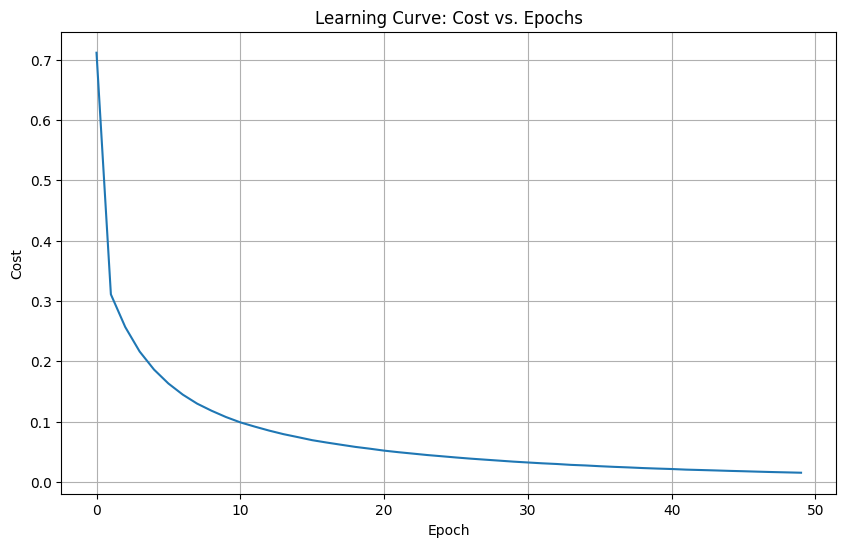

In [40]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))
plt.plot(costs)
plt.title("Learning Curve: Cost vs. Epochs")
plt.xlabel("Epoch")
plt.ylabel("Cost")
plt.grid(True)
plt.show()


## Step 3-3: 用測試集檢驗

In [41]:
# 對測試集進行預測
test_predictions = predict(test_x, trained_parameters)

# test_y_orig 是原始的、非 one-hot 的標籤 (0, 1, 2...)
# 比較預測結果和真實標籤
accuracy = np.mean(test_predictions == test_y_orig) * 100

print(f"模型在測試集上的準確率 (Accuracy): {accuracy:.2f}%")


模型在測試集上的準確率 (Accuracy): 98.03%


## Step 3-4: 計算 Precision 與 Recall

In [42]:
num_classes = 10
# 建立一個 10x10 的矩陣，用來存放混淆矩陣的結果
confusion_matrix = np.zeros((num_classes, num_classes), dtype=int)

# 遍歷所有測試集樣本，填充混淆矩陣
for i in range(len(test_y_orig)):
    true_label = test_y_orig[i]
    predicted_label = test_predictions[i]
    confusion_matrix[true_label, predicted_label] += 1

print("混淆矩陣 (Confusion Matrix):")
print(confusion_matrix)
print("\n" + "=" * 30)


混淆矩陣 (Confusion Matrix):
[[ 970    0    0    0    1    1    3    1    3    1]
 [   0 1123    3    1    0    1    2    1    4    0]
 [   4    2 1010    3    3    0    1    4    5    0]
 [   0    0    5  990    0    5    0    2    4    4]
 [   1    0    3    0  965    0    2    3    0    8]
 [   3    0    0    7    0  871    4    1    5    1]
 [   4    3    1    1    3    3  941    0    2    0]
 [   1    3    8    1    0    0    0 1006    4    5]
 [   5    0    3    3    3    1    3    2  952    2]
 [   1    2    0    6   10    3    1    5    6  975]]



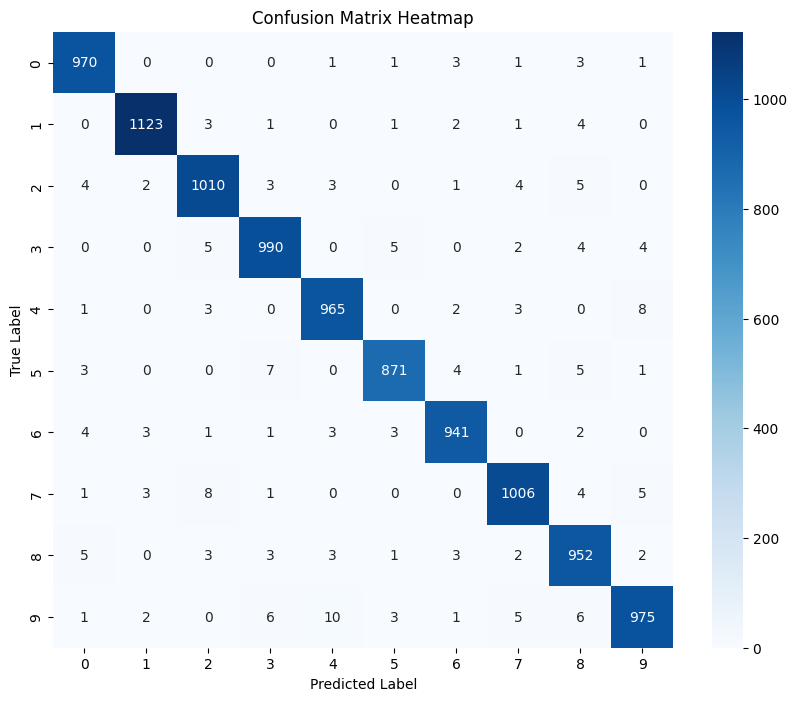

In [43]:
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,  # 在格子中顯示數字
    fmt="d",  # 將數字格式化為整數
    cmap="Blues",  # 使用藍色系的色盤
    xticklabels=range(10), # type: ignore
    yticklabels=range(10), # type: ignore
)
plt.title("Confusion Matrix Heatmap")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [44]:
for i in range(num_classes):
    true_positives = confusion_matrix[i, i]
    false_positives = np.sum(confusion_matrix[:, i]) - true_positives
    false_negatives = np.sum(confusion_matrix[i, :]) - true_positives

    # 避免分母為零的情況
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0

    print(f"數字 '{i}':")
    print(f"  精確率 (Precision): {precision:.4f}")
    print(f"  召回率 (Recall):    {recall:.4f}")


數字 '0':
  精確率 (Precision): 0.9808
  召回率 (Recall):    0.9898
數字 '1':
  精確率 (Precision): 0.9912
  召回率 (Recall):    0.9894
數字 '2':
  精確率 (Precision): 0.9777
  召回率 (Recall):    0.9787
數字 '3':
  精確率 (Precision): 0.9783
  召回率 (Recall):    0.9802
數字 '4':
  精確率 (Precision): 0.9797
  召回率 (Recall):    0.9827
數字 '5':
  精確率 (Precision): 0.9842
  召回率 (Recall):    0.9765
數字 '6':
  精確率 (Precision): 0.9833
  召回率 (Recall):    0.9823
數字 '7':
  精確率 (Precision): 0.9815
  召回率 (Recall):    0.9786
數字 '8':
  精確率 (Precision): 0.9665
  召回率 (Recall):    0.9774
數字 '9':
  精確率 (Precision): 0.9789
  召回率 (Recall):    0.9663


# Step 4: Conclusion

本次作業成功地從零開始，僅使用 NumPy 實現了一個能夠對 MNIST 手寫數字進行高精度分類的雙層神經網路。在使用 256 個隱藏層神經元，經過 50 個 epoch 的訓練後，模型在測試集上達到了 98.03% 的優異準確率 。我們進一步透過混淆矩陣分析了模型對每個數字的詳細預測情況 ，並計算了各類別的精確率 (Precision) 與召回率 (Recall) 。結果顯示，模型對於所有數字（0-9）均有穩健且高水準的辨識能力，例如數字 '1' 的精確率為 0.9912，召回率為 0.9894。並且所有類別的 Precision 和 Recall 皆維持在 0.96 以上。

透過 Confusion Matrix Heapmap 能更深入地分析模型的具體表現。圖中清晰的對角線顯示，絕大多數的樣本都被正確分類。例如，在 '1' 的測試樣本中，模型成功辨識了 1123 個。同時，從非對角線的數值中也能發現一些有趣的混淆情況，例如有 10 次將真實的 '9' 預測為 '4' ，以及 8 次將 '4' 預測為 '9' 。這些特定的錯誤，為未來優化模型提供了改進的方向。